In [1]:
# c_param 10, no heuristic

In [1]:
import numpy as np
from collections import defaultdict
import pickle
from itertools import product
import time
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Model

In [49]:
a = {}
b = a.update({'f':1})
b   

In [92]:
class MonteCarloTreeSearchNode:
    def __init__(self, state=((0,0,0),(0,0,0),(0,0,0)), parent=None, parent_action=None, state_tbl={}):
        # self.state is the 3x3 board with:
        #    1 is player 1 (X), 
        #   -1 is player 2 (O),
        #    0 represents an empty tictactoe cell
        self.state = state
        self.parent = parent
        # parent_action is the move on the tictactoe grid (i,j) to init this tree node
        self.parent_action = parent_action
        self.state_tbl = state_tbl

        self.children = np.array([], dtype=MonteCarloTreeSearchNode)
        self._number_of_visits = 0
        self.tie_reward_scalar = 0.5
        self.c_param = 1

        self._results = defaultdict(int)
        # wins
        self._results[1] = 0
        # ties
        self._results[0] = 0
        # losses
        self._results[-1] = 0
        self._untried_actions = self.get_legal_actions()
        self.is_terminal_node_ = len(self._untried_actions) == 0
        if len(self._untried_actions) % 2 == 0:
            self.player = 1
        else:
            self.player = -1
        self.batch_evaluation = []


    def get_legal_actions(self, given_state=None): 
        if given_state is None:
            state = self.state
        else:
            state = given_state
            
        legal_actions = np.empty([0,2],dtype=int)
        for row, col in product(range(3), range(3)):
            if state[row][col] == 0:
                legal_actions = np.append(legal_actions,[(row,col)], axis=0)
        return legal_actions

    def q(self):
        wins = self._results[1]
        ties = self._results[0]
        return wins + self.tie_reward_scalar * ties

    def n(self):
        return self._number_of_visits

    def set_state_tbl(self, tbl):
        self.state_tbl = tbl
    
    def expand(self):   
        action = self._untried_actions[0]
        self._untried_actions = np.delete(self._untried_actions, 0, axis=0)
        next_state = self.move(action)

        child_node = None
        if next_state in self.state_tbl:
            # child state already in lookup table

            # add self as a parent in lookup table
            self.state_tbl['parents'].append(self)

            # add child from lookup table as to self.children
            self.children = np.append(self.children, self.state_tbl['node'])

            if self.state_tbl['node'].n == 0:
                child_node = self.state_tbl['node']
        else:
            child_node = MonteCarloTreeSearchNode(next_state, parent=self, parent_action=action)
            self.state_tbl[next_state] = {'node':child_node, 'parents':[self]}
            child_node.set_state_tbl(self.state_tbl)
            self.children = np.append(self.children, child_node)
        return child_node 
    
    def rollout(self):
        current_rollout_state = self.state
        result = self.game_result()
        next_player = -self.player
        while result is None:
            possible_moves = self.get_legal_actions(current_rollout_state)

            action = self.rollout_policy(possible_moves)
            current_rollout_state = self.move(action, current_rollout_state, next_player)
            next_player = -next_player
            result = self.game_result(current_rollout_state)
        return result

    def backpropagate(self, result, marked=set([])):
        self._number_of_visits += 1.
        self._results[result] += 1.
        if not self.parent: return
        
        marked.add(id(self))
        for parent in self.state_tbl[self.state]['parents']:
            if id(parent) in marked: continue
            # negative result to alternate between players
            parent.backpropagate(-result, marked)

    def is_fully_expanded(self):
        return len(self._untried_actions) == 0
    
    def best_child(self):
        choices_weights = [(child.q() / child.n()) + self.c_param * np.sqrt( (2 * np.log(self.n()) ) / child.n()) for child in self.children]
        return self.children[np.argmax(choices_weights)]
    
    def rollout_policy(self, possible_moves):
        """ Return a random move from the available moves """
        return np.array(possible_moves[np.random.randint(len(possible_moves))])
    
    def is_terminal_node(self) -> bool:
        """return whether this MCTS node has a game ending state"""
        # or (self.game_result(self.state) is not None)
        return self.is_terminal_node_

    def _tree_policy(self):
        """ Return the next node in the rollout """
        current_node = self
        while not current_node.is_terminal_node():
            if current_node.is_fully_expanded():
                current_node = current_node.best_child()
            else:
                # temp is none if expanding resulted in node already in lookup table
                temp = current_node.expand()
                if temp: return temp
        return current_node
    
    def game_result(self, given_state=None):
        """
        return game result from a state.

        params:
            given_state : 2D int np.array
        
        returns:
             1 => player 1 (X) wins
            -1 => player 2 (O) wins
             0 => tie
            None => game is not over
        """
        if given_state is None:
            s = self.state
        else:
            s = given_state

        game_result = None
        # check rows and cols
        if s[0][0] == s[0][1] == s[0][2] != 0: 
            game_result = s[0][0]
        elif s[1][0] == s[1][1] == s[1][2] != 0: 
            game_result = s[1][0]
        elif s[2][0] == s[2][1] == s[2][2] != 0:
            game_result = s[2][0]
        elif s[0][0] == s[1][0] == s[2][0] != 0: 
            game_result = s[0][0]
        elif s[0][1] == s[1][1] == s[2][1] != 0: 
            game_result = s[0][1]
        elif s[0][2] == s[1][2] == s[2][2] != 0:
            game_result = s[0][2]
        
        # check diagonals
        elif s[0][0] == s[1][1] == s[2][2] != 0:
            game_result = s[0][0] 
        elif s[0][2] == s[1][1] == s[2][0] != 0:
            game_result = s[0][2]
        
        # check if board is full
        elif len(self.get_legal_actions(s)) == 0:
            game_result = 0
        
        # set terminal_node instance tag
        self.is_terminal_node_ = (given_state is None) and (game_result is not None)
        # game is not over
        return game_result
        
    # return a new state by making a move (aciton) on the given state
    def move(self,action,given_state=None, next_player=None):
        if given_state is None:
            new_state = self.state
        else:
            new_state = given_state
        if next_player is None:
            # -self.player since opponent will be making this move on expand()
            next_player = -self.player

        # make list for mutability
        new_state = list(list(col for col in row) for row in new_state)
        new_state[action[0]][action[1]] = next_player

        # make tuple for dict key compatibility
        new_state = tuple(tuple([col for col in row]) for row in new_state)
        return new_state
    
    def get_player(self):
        return self.player
    
    def train(self, rollouts_to_run, rollouts_sofar, batch_size):
        # variables for runtime analysis
        total_rollouts = rollouts_to_run + rollouts_sofar
        batches_remaining = rollouts_to_run/batch_size
        batch_time = 0
        start = time.perf_counter()
        
        for i in range(rollouts_to_run):

            # ----time prints calls----
            rollouts_sofar += 1
            if (rollouts_sofar+1) % batch_size == 0:
                prev_batch_time = batch_time
                batch_time = (time.perf_counter()-start)/60 
                start = time.perf_counter()
                batches_remaining -= 1
                time_remaining = batch_time * batches_remaining
                batch_time_diff = batch_time - prev_batch_time
                # [x_wins,ties,o_wins] per batch
                self.batch_evaluation.append([self._results[-1],self._results[0],self._results[1]])
                print(f"rollouts_ran: {rollouts_sofar + 1}/{total_rollouts}, estimated_time_remaining: {time_remaining:.2f} min, batch_time_diff: {(batch_time_diff * 60):.2f} sec             ", end='\r')
            # -------------------------
            
            v = self._tree_policy()
            winner = v.rollout()
            if winner == 0:
                # update node weights in rollout given tie
                v.backpropagate(0)
            else:
                # update node weights in rollout given win/loss
                v.backpropagate(1 if winner == v.player else -1)
                
        
        print("\ndone")
        return rollouts_sofar

In [93]:
root = MonteCarloTreeSearchNode(state_tbl={})
for i in range(10):
    root._tree_policy()
root.state_tbl

ZeroDivisionError: float division by zero

# Train

In [55]:
root = MonteCarloTreeSearchNode(state_tbl={})
rollouts_sofar = 0
start = time.perf_counter()
rollouts_sofar = root.train(rollouts_to_run=100000, rollouts_sofar=rollouts_sofar, batch_size=10000)
training_time = time.perf_counter() - start
print("total training time: ", training_time/60, "min")

chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best child
chose best chi

KeyboardInterrupt: 

### Writer

In [ ]:
# activate bool write_mode to write pretrained model to file
write_mode = False
write_file_name = 'new_pre_trained_root.txt'
comment = "50mil rollouts training, no heuristic to always pick immediate mate, fixed rewards (from/to what?), c_param=10, training time:  469.43552361999997 min"

def save_model(write_mode, file_name, comment):
    if not write_mode: return
    model = (root, comment)

    with open(file_name,'wb') as f:
        pickle.dump(model,f)

save_model(write_mode, write_file_name, comment)


### Loader

In [6]:
# MUST DEFNIE MonteCarloTreeSeach Class first in cell below
# activate bool load_mode to load pretrained model from file
load_mode = True
pre_trained_model_file_name = 'pre_trained_root.txt'

# get model from file and print its comment
def load_root(load_mode, file_name):
    if not load_mode: return None
    with open(file_name, 'rb') as f:
        (loaded_root, loaded_comment) = pickle.load(f)
        print(loaded_root)
        print(loaded_comment)
    return loaded_root

root = load_root(load_mode, pre_trained_model_file_name)

50mil training, no heuristic to always pick immediate mate, fixed rewards, c_param=10


# batch_eval

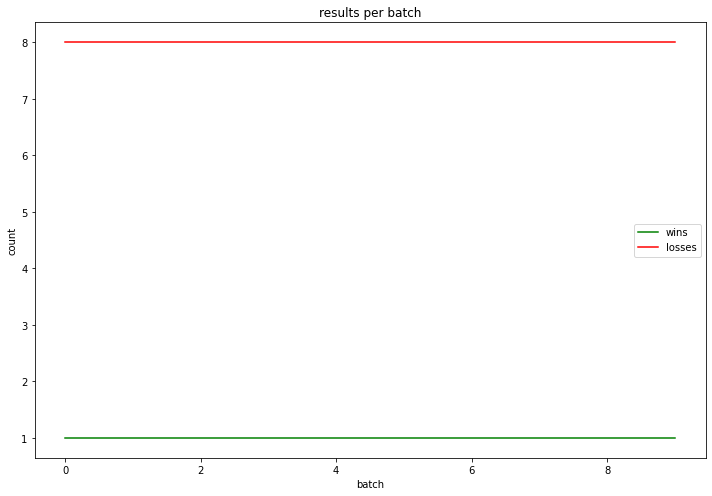

In [52]:
from matplotlib import pyplot as plt
wins = []
ties = []
losses = []
num_batches = len(root.batch_evaluation)
x_list = [i for i in range(num_batches)]
for i, batch in enumerate(root.batch_evaluation):
    losses.append(batch[0])
    ties.append(batch[1])
    wins.append(batch[2])


fig, ax = plt.subplots(figsize=(10,7))
ax.plot(x_list, wins, label='wins', color='green')
ax.plot(losses, label='losses', color='red')
ax.set_title('results per batch')
ax.set_xlabel('batch')
ax.set_ylabel('count')
ax.legend()
plt.tight_layout()
plt.show()

# Nodes found

In [53]:
# bfs 
# pre_trained_root 50mil rollouts -> 549946 nodes found
# ~ 30 sec to run
queue = [root]
count = 0
while queue:
    count += 1
    node = queue.pop(0)
#     print(node.state)
    for c in node.children:
        queue.append(c)
print(count)

36


# Test Perfect Game

In [47]:
# np.array([[key, [val_.state for val_ in val]] for key, val in list(root.state_tbl.items())])
tbl = root.state_tbl
for state in tbl:
    print('state:')
    print(state[0])
    print(state[1])
    print(state[2])
    print('parents:')
    for parent in tbl[state]['parents']:
        print(parent.state)
    print()

state:
(1, 0, 0)
(0, 0, 0)
(0, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 1, 0)
(0, 0, 0)
(0, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 1)
(0, 0, 0)
(0, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 0)
(1, 0, 0)
(0, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 0)
(0, 1, 0)
(0, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 0)
(0, 0, 1)
(0, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 0)
(0, 0, 0)
(1, 0, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 0)
(0, 0, 0)
(0, 1, 0)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(0, 0, 0)
(0, 0, 0)
(0, 0, 1)
parents:
((0, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(1, -1, 0)
(0, 0, 0)
(0, 0, 0)
parents:
((1, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(1, 0, -1)
(0, 0, 0)
(0, 0, 0)
parents:
((1, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(1, 0, 0)
(-1, 0, 0)
(0, 0, 0)
parents:
((1, 0, 0), (0, 0, 0), (0, 0, 0))

state:
(1, 0, 0)
(0, -1, 

In [48]:
curr = root
while curr.game_result() is None:
    print(curr.state)
    print(curr._results)
    print()
    visits = {}
    ratios = {}
    max_visits = -1
    max_ratio = -1
 
    # MAX VISITS
    for c in curr.children:
        print(c.parent_action, int(c._number_of_visits), (c.q() / c.n()) + c.c_param * np.sqrt((2 * np.log(curr.n()) / c.n())))
        if c._number_of_visits >= max_visits:
            max_visits = c._number_of_visits
            if max_visits in visits:
                visits[max_visits].append(c)
            else:
                visits[max_visits] = [c]
        if len(visits[max_visits]) > 1:
            child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
        else:
            child = visits[max_visits][0]
    curr = child

    # BEST_CHILD
#     curr = curr.best_child()

print(curr.state)
print(curr._results)

((0, 0, 0), (0, 0, 0), (0, 0, 0))
defaultdict(<class 'int'>, {1: 3.0, 0: 1.0, -1: 5.0})

[0 0] 1 3.09629414793641
[0 1] 1 2.09629414793641
[0 2] 1 3.09629414793641
[1 0] 1 3.09629414793641
[1 1] 1 2.59629414793641
[1 2] 1 2.09629414793641
[2 0] 1 2.09629414793641
[2 1] 1 3.09629414793641
[2 2] 1 3.09629414793641
((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0, 0), (0, 0, 0), (0, 0, 1))
defaultdict(<class 'int'>, {1: 1.0, 0: 0, -1: 0})

((0, 0

KeyboardInterrupt: 

# Error test

In [8]:
curr = root
actions = [np.array([0,1]),np.array([0,2]),np.array([2,1])]
for i, action in enumerate(actions):
    for c_ in curr.children:
        if np.equal(c_.parent_action, action).all():
            curr = c_

            visits = {}
            max_visits = -1
            # MAX VISITS
            for c in curr.children:
                if c._number_of_visits >= max_visits:
                    max_visits = c._number_of_visits
                    if max_visits in visits:
                        visits[max_visits].append(c)
                    else:
                        visits[max_visits] = [c]
                if len(visits[max_visits]) > 1:
                    child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
                else:
                    child = visits[max_visits][0]
            curr = child
            
            break
test_curr = curr

# GUI

In [80]:
from tkinter import *
import numpy as np
import time


size_of_board = 600
symbol_size = (size_of_board / 3 - size_of_board / 8) / 2
symbol_thickness = 50
symbol_X_color = '#EE4035'
symbol_O_color = '#0492CF'
win_line_color = '#000000'
Green_color = '#7BC043'


class Tic_Tac_Toe():
    # ------------------------------------------------------------------
    # Initialization Functions:
    # ------------------------------------------------------------------
    def __init__(self, root, player_first):
        self.window = Tk()
        self.window.title('Tic-Tac-Toe')
        self.canvas = Canvas(self.window, width=size_of_board, height=size_of_board)
        self.canvas.pack()
        # Input from user in form of clicks
        self.window.bind('<Button-1>', self.click)

        self.board_status = np.zeros(shape=(3, 3))

        self.player_X_starts = True if player_first else False
        self.reset_board = False
        self.gameover = False
        self.tie = False
        self.X_wins = False
        self.O_wins = False

        self.X_score = 0
        self.O_score = 0
        self.tie_score = 0
        
        self.root = root
        self.curr = root
        self.initialize_board()

    def mainloop(self):
        self.window.mainloop()

    def initialize_board(self):
        for i in range(2):
            self.canvas.create_line((i + 1) * size_of_board / 3, 0, (i + 1) * size_of_board / 3, size_of_board)

        for i in range(2):
            self.canvas.create_line(0, (i + 1) * size_of_board / 3, size_of_board, (i + 1) * size_of_board / 3)
            
        if not self.player_X_starts:
            max_visits = -1
            visits = {}
            for c in self.curr.children:
                if c._number_of_visits >= max_visits:
                    max_visits = c._number_of_visits
                    if max_visits in visits:
                        visits[max_visits].append(c)
                    else:
                        visits[max_visits] = [c]
                if len(visits[max_visits]) > 1:
                    child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
                else:
                    child = visits[max_visits][0]
            self.curr = child
            AI_logical_pos = np.array([self.curr.parent_action[1],self.curr.parent_action[0]])
            print("AI    ", AI_logical_pos)
            self.draw_O(AI_logical_pos)
            self.board_status[AI_logical_pos[0]][AI_logical_pos[1]] = 1

    def play_again(self):
        self.curr = self.root
        self.board_status = np.zeros(shape=(3, 3))
        self.initialize_board()

    # ------------------------------------------------------------------
    # Drawing Functions:
    # The modules required to draw required game based object on canvas
    # ------------------------------------------------------------------

    def draw_O(self, logical_position):
        logical_position = np.array(logical_position)
        # logical_position = grid value on the board
        # grid_position = actual pixel values of the center of the grid
        grid_position = self.convert_logical_to_grid_position(logical_position)
        self.canvas.create_oval(grid_position[0] - symbol_size, grid_position[1] - symbol_size,
                                grid_position[0] + symbol_size, grid_position[1] + symbol_size, width=symbol_thickness,
                                outline=symbol_O_color)

    def draw_X(self, logical_position):
        grid_position = self.convert_logical_to_grid_position(logical_position)
        self.canvas.create_line(grid_position[0] - symbol_size, grid_position[1] - symbol_size,
                                grid_position[0] + symbol_size, grid_position[1] + symbol_size, width=symbol_thickness,
                                fill=symbol_X_color)
        self.canvas.create_line(grid_position[0] - symbol_size, grid_position[1] + symbol_size,
                                grid_position[0] + symbol_size, grid_position[1] - symbol_size, width=symbol_thickness,
                                fill=symbol_X_color)

    def display_gameover(self):

        if self.X_wins:
            self.X_score += 1
            text = 'Winner: Human (X)'
            color = symbol_X_color
        elif self.O_wins:
            self.O_score += 1
            text = 'Winner: AI (O)'
            color = symbol_O_color
        else:
            self.tie_score += 1
            text = 'Its a tie'
            color = 'gray'

        self.canvas.delete("all")
        self.canvas.create_text(size_of_board / 2, size_of_board / 3, font="cmr 40 bold", fill=color, text=text)

        score_text = 'Scores \n'
        self.canvas.create_text(size_of_board / 2, 5 * size_of_board / 8, font="cmr 40 bold", fill=Green_color,
                                text=score_text)

        score_text = 'Human (X) :    ' + str(self.X_score) + '\n'
        score_text += 'AI (O)           : ' + str(self.O_score) + '\n'
        score_text += 'Tie                : ' + str(self.tie_score)
        self.canvas.create_text(size_of_board / 2, 3 * size_of_board / 4, font="cmr 30 bold", fill=Green_color,
                                text=score_text)
        self.reset_board = True
        self.gameover = False

        play_agian_text = 'Click to play again \n'
        self.canvas.create_text(size_of_board / 2, 15 * size_of_board / 16, font="cmr 20 bold", fill="gray",
                                text=play_agian_text)

    # ------------------------------------------------------------------
    # Logical Functions:
    # The modules required to carry out game logic
    # ------------------------------------------------------------------

    def convert_logical_to_grid_position(self, logical_position):
        logical_position = np.array(logical_position, dtype=int)
        return (size_of_board / 3) * logical_position + size_of_board / 6

    def convert_grid_to_logical_position(self, grid_position):
        grid_position = np.array(grid_position)
        return np.array(grid_position // (size_of_board / 3), dtype=int)

    def is_grid_occupied(self, logical_position):
        if self.board_status[logical_position[0]][logical_position[1]] == 0:
            return False
        else:
            return True

    def is_winner(self, player):

        player = -1 if player == 'X' else 1

        # Three in a row
        for i in range(3):
            if self.board_status[i][0] == self.board_status[i][1] == self.board_status[i][2] == player:
                return True
            if self.board_status[0][i] == self.board_status[1][i] == self.board_status[2][i] == player:
                return True

        # Diagonals
        if self.board_status[0][0] == self.board_status[1][1] == self.board_status[2][2] == player:
            return True

        if self.board_status[0][2] == self.board_status[1][1] == self.board_status[2][0] == player:
            return True

        return False

    def is_tie(self):

        r, c = np.where(self.board_status == 0)
        tie = False
        if len(r) == 0:
            tie = True

        return tie

    def is_gameover(self):
        # Either someone wins or all grid occupied
        self.X_wins = self.is_winner('X')
        if not self.X_wins:
            self.O_wins = self.is_winner('O')

        if not self.O_wins:
            self.tie = self.is_tie()

        gameover = self.X_wins or self.O_wins or self.tie

        if self.X_wins:
            print('X wins')
        if self.O_wins:
            print('O wins')
        if self.tie:
            print('Its a tie')

        return gameover

    def display_result(self, node):
        self.gameover = True
        s = node.state
        #check if rows and cols
        if s[0][0] == s[0][1] == s[0][2] != 0: 
            self.canvas.create_line(size_of_board / 12, size_of_board / 6, size_of_board - (size_of_board / 12), 
                                    size_of_board / 6, width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[1][0] == s[1][1] == s[1][2] != 0: 
            self.canvas.create_line(size_of_board / 12, size_of_board / 2, size_of_board - (size_of_board / 12), 
                                    size_of_board / 2, width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[2][0] == s[2][1] == s[2][2] != 0:
            self.canvas.create_line(size_of_board / 12, 5*(size_of_board / 6), size_of_board - (size_of_board / 12), 
                                    5*(size_of_board / 6), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][0] == s[1][0] == s[2][0] != 0: 
            self.canvas.create_line(size_of_board / 6, size_of_board / 12, size_of_board / 6, 
                                    size_of_board - (size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][1] == s[1][1] == s[2][1] != 0: 
            self.canvas.create_line(size_of_board / 2, size_of_board / 12, size_of_board / 2, 
                                    size_of_board - (size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][2] == s[1][2] == s[2][2] != 0:
            self.canvas.create_line(5*(size_of_board / 6), size_of_board / 12, 5*(size_of_board / 6), 
                                    size_of_board - (size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        
        #check diagonals
        elif s[0][0] == s[1][1] == s[2][2] != 0:
            self.canvas.create_line(size_of_board / 12, size_of_board / 12, size_of_board - (size_of_board / 12), 
                                    size_of_board-(size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        elif s[0][2] == s[1][1] == s[2][0] != 0:
            self.canvas.create_line(size_of_board - (size_of_board / 12), size_of_board / 12, size_of_board / 12, 
                                    size_of_board-(size_of_board / 12), width = symbol_thickness/2,
                                    fill=win_line_color)
        
        


    def click(self, event):
        grid_position = [event.x, event.y]
        logical_position = self.convert_grid_to_logical_position(grid_position)

        if self.gameover:
            self.display_gameover()
        elif not self.reset_board:
            if not self.is_grid_occupied(logical_position):
                print("player",logical_position)
                self.draw_X(logical_position)
                self.board_status[logical_position[0]][logical_position[1]] = -1
                for c in self.curr.children:
                    if np.array_equal(c.parent_action, np.array([logical_position[1],logical_position[0]])):
                        self.curr = c
                if self.is_gameover():
                    self.display_result(self.curr)
                else:
                    max_visits = -1
                    visits = {}
                    for c in self.curr.children:
                        if c._number_of_visits >= max_visits:
                            max_visits = c._number_of_visits
                            if max_visits in visits:
                                visits[max_visits].append(c)
                            else:
                                visits[max_visits] = [c]
                        if len(visits[max_visits]) > 1:
                            child = visits[max_visits][np.random.randint(0,len(visits[max_visits]))]
                        else:
                            child = visits[max_visits][0]
                    self.curr = child
                    AI_logical_pos = np.array([self.curr.parent_action[1],self.curr.parent_action[0]])
                    print("AI    ", AI_logical_pos)
                    self.draw_O(AI_logical_pos)
                    self.board_status[AI_logical_pos[0]][AI_logical_pos[1]] = 1
                    


            # Check if game is concluded
            if self.is_gameover():
                self.display_result(self.curr)

        else:  # Play Again
            self.canvas.delete("all")
            self.play_again()
            self.reset_board = False

# Play Game

In [81]:
# True = player starts, False = AI starts
game = Tic_Tac_Toe(root=root, player_first=False)
game.mainloop()

AI     [1 1]
player [2 1]
AI     [2 0]
player [0 2]
AI     [0 0]
player [2 2]
AI     [1 0]
O wins
AI     [1 1]
player [0 2]
AI     [1 2]
player [1 0]
AI     [0 0]
player [2 2]
AI     [2 1]
player [0 1]
AI     [2 0]
Its a tie
AI     [1 1]
player [1 0]
AI     [0 0]
player [2 2]
AI     [0 2]
player [2 1]
AI     [0 1]
O wins
AI     [1 1]
player [0 0]
AI     [1 0]
player [1 2]
AI     [0 1]
player [2 1]
AI     [2 0]
player [2 2]
AI     [0 2]
O wins
AI     [1 1]
player [2 0]
AI     [1 0]
player [1 2]
AI     [2 2]
player [0 0]
AI     [2 1]
player [0 1]
AI     [0 2]
Its a tie
AI     [1 1]
player [0 0]
AI     [1 0]
player [1 2]
AI     [0 1]
player [2 1]
AI     [0 2]
player [2 0]
AI     [2 2]
Its a tie
AI     [1 1]
player [2 1]
AI     [2 0]
player [0 2]
AI     [0 0]
player [2 2]
AI     [1 0]
O wins
